In [ ]:
"""

"""
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import ast
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, date
import scipy

def gaussian_nll(value, mu, sigma):
    # Calculate Gaussian negative log likelihood
    return -np.sum(stats.norm.logpdf(value, loc=mu, scale=sigma))

def diastolic_systolic_clf(value):
    if gaussian_nll(value, mu=127.18, sigma=18.86) <= gaussian_nll(value, mu=69.49, sigma=11.54):
        return "systolic"
    return "diastolic" 

def compute_age(date_of_birth):
    if not date_of_birth:
        return None
    date_of_birth = datetime.strptime(date_of_birth, "%Y-%m-%d").date()
    today = date.today()
    # check if this year's birthday has passed:
    offset = int((today.month, today.day) < (date_of_birth.month, date_of_birth.day))

    return today.year - date_of_birth.year - offset

protocol_id_list = [
    "LFE-0001-P0xzY-P-CiNaP", 
    "LFE-0001-P0xzY-P-32tKi", 
    "LFE-0001-P0xzY-P-LfhYX",
    "LFE-0001-P0xzY-P-Ot6SI",
    "LFE-0001-P0xzY-P-VNg6R",
    ]

metadata_df = pd.read_csv("../data/clustering_metadata_la_fe.csv", index_col=0)
metadata_df.set_index("patient_id", inplace=True)
metadata_df["age"] = metadata_df["birth_date"].apply(compute_age)
metadata_df.drop(["protocol_id", "protocol_name"], axis=1, inplace=True)
metadata_df.drop_duplicates(inplace=True)
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 6gclT6rWzsXwLtFe0pec to vfsHLYsatEVLs2Ncp7Ne
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gender      90 non-null     object
 1   birth_date  90 non-null     object
 2   age         90 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ KB


In [ ]:
data = []
for protocol_id in protocol_id_list:
    df = pd.read_csv(f"../data/{protocol_id}.csv", header=0, usecols=common_vars)
    df["protocol_id"] = protocol_id
    data.append(df)
numerical_vals_df = pd.concat(data, axis=0, ignore_index=True)
numerical_vals_df.set_index("patient_id", inplace=True)
numerical_vals_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, OTHPmMjsxRjAfzcVKQ3x to S7v9wQr0fyYBPuI92RAU
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   conversation_id        344 non-null    object
 1   date                   344 non-null    object
 2   medication_compliance  344 non-null    int64 
 3   wellbeing_qual         344 non-null    int64 
 4   hospitalization        344 non-null    int64 
 5   death                  344 non-null    int64 
 6   eat_well               344 non-null    int64 
 7   eat_quant              344 non-null    int64 
 8   is_vomiting            344 non-null    int64 
 9   is_fatigued            344 non-null    int64 
 10  fatigue_quant          344 non-null    int64 
 11  has_high_fever         344 non-null    int64 
 12  high_fever_days        344 non-null    int64 
 13  blood_pressure         344 non-null    object
 14  heart_rate             344 non-null    int6

Systolic:
Average = 127.18, Standard Deviation = 18.86

Diastolic:
Average = 69.49, Standard Deviation = 11.54


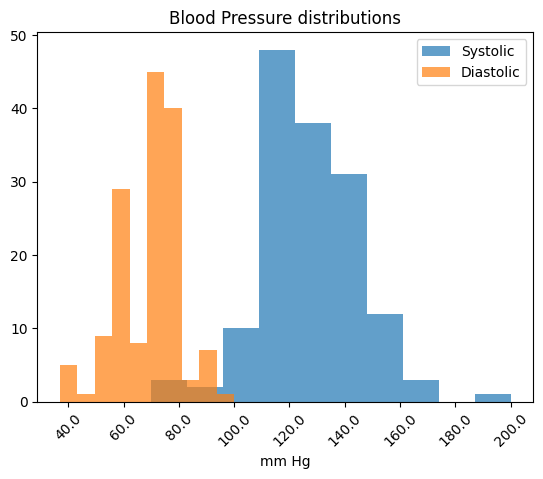

In [4]:
# Parse complete blood pressure data
full_blood_pressures_list = []
for bps in numerical_vals_df["blood_pressure"].values.tolist():
    bps_parsed = ast.literal_eval(bps)
    if bps_parsed != 0:
        if len(bps_parsed) == 2:
            pressures = list(map(int, bps_parsed))
            if pressures[0] < pressures[1]:
                pressures.reverse()
            full_blood_pressures_list.append(pressures)
full_blood_pressures = np.array(full_blood_pressures_list)

# Plot histograms and estimate distribution parameters
fig, ax = plt.subplots()
ax.hist(full_blood_pressures[:, 0], alpha=0.7, label="Systolic")
ax.hist(full_blood_pressures[:, 1], alpha=0.7, label="Diastolic")
ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.set_xlabel("mm Hg")
ax.legend()
ax.set_title("Blood Pressure distributions")

mu_high = full_blood_pressures[:, 0].mean()
std_high = full_blood_pressures[:, 0].std()
mu_low = full_blood_pressures[:, 1].mean()
std_low = full_blood_pressures[:, 1].std()

print(f"Systolic:\nAverage = {mu_high:.2f}, Standard Deviation = {std_high:.2f}")
print(f"\nDiastolic:\nAverage = {mu_low:.2f}, Standard Deviation = {std_low:.2f}")

In [5]:
# Separate blood pressure values into systolic/diastolic
numerical_vals_df["systolic_bp"] = np.nan
numerical_vals_df["diastolic_bp"] = np.nan
for idx, bps in enumerate(numerical_vals_df["blood_pressure"].values.tolist()):
    bps_parsed = ast.literal_eval(bps)
    if bps_parsed != 0:
        if len(bps_parsed) == 2:
            # complete reading: separate
            pressures = list(map(int, bps_parsed))
            if pressures[0] < pressures[1]:
                pressures.reverse()
            numerical_vals_df.iloc[idx, -2] = pressures[0]
            numerical_vals_df.iloc[idx, -1] = pressures[1]
        if len(bps_parsed) == 1:
            # incomplete reading: classify
            value = int(bps_parsed[0])
            if diastolic_systolic_clf(int(bps_parsed[0])) == "systolic":
                numerical_vals_df.iloc[idx, -2] = value
            else:
                numerical_vals_df.iloc[idx, -1] = value
numerical_vals_df = numerical_vals_df.drop(["blood_pressure"], axis=1)

In [7]:
# Get traininng data for regression models
training_df = numerical_vals_clean.dropna()

In [8]:
# Data for diastolic bp predictor
X = training_df[["gender_male", "age", "systolic_bp"]].values
diastolic_scaler = StandardScaler()
X_std = diastolic_scaler.fit_transform(X)
y = training_df["diastolic_bp"].values

In [9]:
# Validate parameters for diastolic bp predictor
model = KernelRidge()
parameters = {
    'kernel':('linear', 'rbf'), 
    'alpha': np.logspace(-2, 2, 50),
    'gamma': np.logspace(-4, 0, 50),
    }
clf = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
clf.fit(X_std, y)

GridSearchCV(cv=10, estimator=KernelRidge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01,...
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00]),
                         'kernel': ('linear', 'rbf')})

In [10]:
# Validation resutls
print(clf.best_params_)
print(clf.best_score_)
diastolic_predictor = clf.best_estimator_

{'alpha': 0.0655128556859551, 'gamma': 0.0009540954763499944, 'kernel': 'rbf'}
0.1579645198477854


In [11]:
# Data for systolic bp predictor
X = training_df[["gender_male", "age", "diastolic_bp"]].values
systolic_scaler = StandardScaler()
X_std = systolic_scaler.fit_transform(X)
y = training_df["systolic_bp"].values

In [12]:
# Validate parameters for systolic bp predictor
model = KernelRidge()
parameters = {
    'kernel':('linear', 'rbf'), 
    'alpha': np.logspace(-2, 2, 50), 
    'gamma': np.logspace(-3, 0, 50),
    }
clf = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
clf.fit(X_std, y)

GridSearchCV(cv=10, estimator=KernelRidge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.67683294e-01,
       2.02358965e-01, 2.44205309e-01,...
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'kernel': ('linear', 'rbf')})

In [13]:
# Validation resutls
print(clf.best_params_)
print(clf.best_score_)
systolic_predictor = clf.best_estimator_

{'alpha': 1.5998587196060574, 'gamma': 0.008286427728546842, 'kernel': 'rbf'}
-0.34454536410382647


In [14]:
# Estimate missing blood pressure values.
for index, data in numerical_vals_clean.iterrows():
    state = (np.isnan(data["systolic_bp"]), np.isnan(data["diastolic_bp"]))
    if state[0] < state[1]:
        print("\nEstimating diastolic blood pressure.")
        print(data.loc[["gender_male", "age", "systolic_bp"]].to_string())
        X = data.loc[["gender_male", "age", "systolic_bp"]].values.reshape(1, -1)
        X_std = diastolic_scaler.transform(X)
        y = diastolic_predictor.predict(X_std)[0]
        numerical_vals_clean.loc[index, "diastolic_bp"] = y
        print(f"Estimation = {y:.2f}")
    elif state[0] > state[1]:
        print("\nEstimating systolic blood pressure...")
        print(data.loc[["gender_male", "age", "diastolic_bp"]].to_string())
        X = data.loc[["gender_male", "age", "diastolic_bp"]].values.reshape(1, -1)
        X_std = systolic_scaler.transform(X)
        y = systolic_predictor.predict(X_std)[0]
        numerical_vals_clean.loc[index, "systolic_bp"] = y
        print(f"Estimation = {y:.2f}")


Estimating diastolic blood pressure.
gender_male        0
age              101
systolic_bp    150.0
Estimation = 70.74

Estimating diastolic blood pressure.
gender_male        0
age              101
systolic_bp    160.0
Estimation = 73.11

Estimating diastolic blood pressure.
gender_male        0
age              101
systolic_bp    140.0
Estimation = 68.32

Estimating diastolic blood pressure.
gender_male        1
age               82
systolic_bp    120.0
Estimation = 68.36

Estimating diastolic blood pressure.
gender_male        1
age               89
systolic_bp    120.0
Estimation = 67.31

Estimating diastolic blood pressure.
gender_male        1
age               89
systolic_bp    140.0
Estimation = 72.27

Estimating diastolic blood pressure.
gender_male        0
age               82
systolic_bp    115.0
Estimation = 65.06

Estimating diastolic blood pressure.
gender_male        1
age               85
systolic_bp    147.0
Estimation = 74.57

Estimating diastolic blood pressure.
ge